In [ ]:
#!wget https://www.cbica.upenn.edu/MICCAI_BraTS2020_TrainingData

In [ ]:
#!cp /content/MICCAI_BraTS2020_TrainingData /content/drive/MyDrive

In [ ]:
#@title
from PIL import Image                                      # (pip install Pillow)
import numpy as np                                         # (pip install numpy)
from skimage import measure                                # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon         # (pip install Shapely)
import os
import json

def create_sub_masks(mask_image,category_colors):
    # Initialize a dictionary of sub-masks indexed by category_colors
    
    sub_masks = {}

    keys = category_colors.keys()
    for key in keys:
      sub_masks[key] = np.isin(mask_image, category_colors[key])

    return sub_masks

def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(0.5, preserve_topology=False)
        
        if(poly.area < 10):
            # Go to next iteration, dont save empty values in list
            continue


        polygons.append(poly)
        
        # segmentation = np.array(poly.exterior.coords).ravel().tolist()
        # segmentations.append(segmentation)
    
    return polygons, segmentations

def create_category_annotation(category_dict):
    category_list = []

    for key, value in category_dict.items():
        category = {
            "supercategory": key,
            "id": value,
            "name": key
        }
        category_list.append(category)

    return category_list

def create_image_annotation(file_name, width, height, image_id):
    images = {
        "file_name": file_name,
        "height": height,
        "width": width,
        "id": image_id
    }

    return images

def create_annotation_format(polygon, segmentation, image_id, category_id, annotation_id):
    min_x, min_y, max_x, max_y = polygon.bounds
    width = max_x - min_x
    height = max_y - min_y
    bbox = (min_x, min_y, width, height)
    area = polygon.area

    annotation = {
        "segmentation": segmentation,
        "area": area,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": bbox,
        "category_id": category_id,
        "id": annotation_id
    }

    return annotation

def get_coco_json_format():
    # Standard COCO format 
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [{}],
        "categories": [{}],
        "annotations": [{}]
    }

    return coco_format

In [ ]:
!unzip /content/drive/MyDrive/MICCAI_BraTS2020_TrainingData

Archive:  /content/drive/MyDrive/MICCAI_BraTS2020_TrainingData
   creating: MICCAI_BraTS2020_TrainingData/
   creating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz  
   creating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii.gz  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii.gz  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Tr

In [ ]:
!pip -q install SimpleITK==2.1.1
!pip -q install nibabel

     |████████████████████████████████| 48.4 MB 20 kB/s 


In [ ]:
import zipfile  # For file extraction
import glob  # For retrieving files/pathnames matching a specified pattern
import re # specifies a set of strings that matches it
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons

In [ ]:
t1 = glob.glob('/content/MICCAI_BraTS2020_TrainingData/*/*t1.nii.gz')
t2 = glob.glob('/content/MICCAI_BraTS2020_TrainingData/*/*t2.nii.gz')
flair = glob.glob('/content/MICCAI_BraTS2020_TrainingData/*/*flair.nii.gz')
t1ce = glob.glob('/content/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii.gz')
seg = glob.glob('/content/MICCAI_BraTS2020_TrainingData/*/*seg.nii.gz')  # Ground Truth
pattern = re.compile('/content/MICCAI_BraTS2020_TrainingData/.*_(\w*)\.nii\.gz')

data_paths = [{
    pattern.findall(item)[0]:item for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

print('number of training examples' ,len(data_paths))
print(data_paths[0])

number of training examples 369
{'t1': '/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356/BraTS20_Training_356_t1.nii.gz', 't2': '/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356/BraTS20_Training_356_t2.nii.gz', 't1ce': '/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356/BraTS20_Training_356_t1ce.nii.gz', 'flair': '/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356/BraTS20_Training_356_flair.nii.gz', 'seg': '/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356/BraTS20_Training_356_seg.nii.gz'}


In [ ]:
def read_img_sitk(img_path):
  image_data = sitk.ReadImage(img_path)
  return image_data
def read_img_nii(img_path):
  image_data = np.array(nib.load(img_path).get_fdata())
  return image_data
np_img = read_img_nii(data_paths[0]['seg'])
sitk_img = read_img_sitk(data_paths[0]['seg'])
#Check shape of images

np_shape = np_img.shape
sitk_shape = sitk_img.GetSize()
print("Shape of np_img : ", np_shape)
print("Shape of sitk_img : ", sitk_shape)

Shape of np_img :  (240, 240, 155)
Shape of sitk_img :  (240, 240, 155)


In [ ]:

@interact
def explore_3dimage(layer = [l for l in range(156)] , modality=['t1', 't2', 't1ce', 'flair','seg'] , view = ['axial' , 'sagittal' , 'coronal'], patient= [l for l in range(370)] ): 
    if modality == 't1':
      modal = 't1'
    elif modality == 't2':
      modal = 't2'
    elif modality == 't1ce':
      modal = 't1ce'
    elif modality == 'flair':
      modal = 'flair'
    elif modality == 'seg':
      modal = 'seg'
    else :
      print("Error")

    
    image = read_img_nii(data_paths[patient][modal])
    array_view = (image)

    if view == 'axial':
      array_view = array_view[layer, :,:]
    elif view == 'coronal':
      array_view = array_view[:, layer, :]
    elif view == 'sagittal':
      array_view = array_view[:, : ,layer]
    else:
      print("Error")
    print(array_view.shape)
    plt.figure(figsize=(10, 5))
    plt.imshow(array_view, cmap='gray')
    # plt.title('Explore Layers of Brain', fontsize=10)
    plt.axis('off')

# Some tests

## bar plot of the area

In [ ]:
test = np.load('/content/images/image2_109.npz')['arr_0']

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test[:,:,1])
plt.show()

In [ ]:
edema = []
enhance = []
necrotic = []
for case in data_paths:
  case_seg = read_img_nii(case['seg'])
  for mask in range((case_seg.shape[2])):
    
    edema.append(np.sqrt(np.isin(case_seg[:,:,mask], [1,2,4]).sum()))
    enhance.append(np.sqrt(np.isin(case_seg[:,:,mask], [1,4]).sum()))
    necrotic.append(np.sqrt(np.isin(case_seg[:,:,mask] , [1]).sum()))

In [ ]:
import plotly.express as px

fig = px.histogram({'edema':edema,'enhancing':enhance,'necrotic':necrotic}, barmode='group', nbins=10)
fig.show()

## bar plot of the distance between ploygons

In [ ]:
import itertools

def processMask(mask):
  contours = measure.find_contours(mask, 0.5, positive_orientation="low")
  polygons = []

  for contour in contours:
      # Flip from (row, col) representation to (x, y)
      # and subtract the padding pixel
      for i in range(len(contour)):
          row, col = contour[i]
          contour[i] = (col - 1, row - 1)

      # Make a polygon and simplify it
      poly = Polygon(contour)
      if(poly.area < 1):
          # Go to next iteration, dont save empty values in list
          continue
      polygons.append(poly)

  all_conbinations = itertools.combinations(polygons, 2)
  distances = []
  for p1, p2 in all_conbinations:
    
    distances.append(p1.distance(p2))
  if distances:

    return max(distances)
  else:
    return 0.

In [ ]:
from tqdm import tqdm
wholeTumor = []
tumorCore = []
enhance = []
for case in tqdm(data_paths):
  case_seg = read_img_nii(case['seg'])
  for scan_slice in range((case_seg.shape[2])):
    mask = case_seg[:,:,scan_slice]
    if mask.any():
      wholeTumor.append(processMask(np.isin(mask, [1,2,4])))
      tumorCore.append(processMask(np.isin(mask, [1,4])))
      enhance.append(processMask(np.isin(mask , [4])))

100%|██████████| 369/369 [03:10<00:00,  1.93it/s]


In [ ]:
import plotly.express as px

fig = px.histogram({'wholeTumor':wholeTumor,'enhancing':enhance,'tumorCore':tumorCore}, barmode='group', nbins=0)
fig.show()

## overlapping boxes
trying to find instances with the same boxe coordinates, to prove that mask rcnn can't handle the full three classes of brain tumor

In [ ]:
!tar -xf /content/drive/MyDrive/bratsV8.tar.gz

tar: /content/drive/MyDrive/bratsV8.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import json
with open('train.json') as f:
  test_train = json.load(f)

In [ ]:
test_train.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [ ]:
from pycocotools.coco import COCO
coco = COCO('train.json')

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [ ]:
coco.getCatIds()

[1, 2, 3]

In [ ]:
from itertools import product, permutations

In [ ]:
cat_ids = coco.getCatIds()
n = 0
y = 0
for id in coco.getImgIds():
  en_anns = coco.getAnnIds(imgIds=[id], catIds=3)
  tc_anns = coco.getAnnIds(imgIds=[id], catIds=2)
  wt_anns = coco.getAnnIds(imgIds=[id], catIds=1)
  l = list(product(en_anns, tc_anns, wt_anns))
 
  for c in l:
    n += 1
    
    assert len(coco.loadAnns(c[0])) == 1
    if coco.loadAnns(c[0])[0]['bbox'] ==  coco.loadAnns(c[2])[0]['bbox']:
      y += 1

In [ ]:
print(f'number of tries {n}, cases where wt == enhancing {y}, percent {y/n}')

number of tries 18297, cases where wt == enhancing 237, percent 0.01295294310542712


In [ ]:
print(f'number of tries {n}, cases where tc == wt {y}, percent {y/n}')

number of tries 18297, cases where tc == wt 443, percent 0.02421161939115702


In [ ]:
print(f'number of tries {n}, cases where tc == enhancing == wt {y}, percent {y/n}')

number of tries 18297, cases where tc == enhancing == wt 190, percent 0.010384215991692628


In [ ]:
print(f'number of tries {n}, cases where tc == enhancing {y}, percent {y/n}')

number of tries 14339, cases where tc == enhancing 6290, percent 0.4386637840853616


## bar plot of iou between boxes

In [ ]:
!tar -xf /content/drive/MyDrive/bratsV11.tar.gz

In [ ]:
from pycocotools.coco import COCO
from itertools import product, permutations, combinations
coco = COCO('train.json')

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  if boxA[0] > boxA[2]:
    boxA[2] = boxA[0] + boxA[2]
    boxA[3] = boxA[1] + boxA[3]
    boxB[2] = boxB[0] + boxB[2]
    boxB[3] = boxB[1] + boxB[3]
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [ ]:

bb_intersection_over_union(coco.loadAnns(100)[0]['bbox'], coco.loadAnns(100)[0]['bbox'])

1.0

In [ ]:
import pycocotools.mask as _mask
iou_list = []
for id in coco.getImgIds():
  wt_anns = coco.getAnnIds(imgIds=[id], catIds=1)
  all_conbinations = combinations(wt_anns, 2)
  
  for ann1, ann2 in all_conbinations:
    
    bbox1 = coco.loadAnns(ann1)[0]['bbox']
    bbox2 = coco.loadAnns(ann2)[0]['bbox']
    iou_list.append( bb_intersection_over_union(bbox1, bbox2) )


In [ ]:
max(iou_list)

0.43872714962762355

In [ ]:
import plotly.express as px

fig = px.histogram({'iou':iou_list}, nbins=10)
fig.show()

## bar plot of the area using the bbox

In [ ]:


for d in random.sample(test_train["annotations"],100):
  print(d['area'])
  plt.imshow(_mask.decode(d['segmentation']))
  plt.show()

In [ ]:
area = []
for d in (test_train["annotations"]):
  area.append(d['area'])

In [ ]:
import plotly.express as px

fig = px.histogram({'area':area}, nbins=0)
fig.show()

# Processing images

In [ ]:
!rm -r /content/images

In [ ]:
import os

os.mkdir('images/')

In [ ]:
from tqdm import tqdm

import time
import multiprocessing
from sklearn.preprocessing import MinMaxScaler


In [ ]:
#@title
def images_annotations_info(mask, img_path,image_id,images,annotations,annotation_id):
  # We make a reference to the original file in the COCO JSON file
    
    original_file_name = img_path

    
    mask_image_open = mask
    w, h = mask_image_open.shape
    
    # "images" info 
    image = create_image_annotation(original_file_name, w, h, image_id)
    images.append(image)



    sub_masks = create_sub_masks(mask_image_open, category_colors)


    for color, sub_mask in sub_masks.items():
      
        
          category_id = color
        # try: 
        # "annotations" info
          polygons, segmentations = create_sub_mask_annotation(sub_mask)

          # Check if we have classes that are a multipolygon
          if category_id in multipolygon_ids:
              # Combine the polygons to calculate the bounding box and area
              multi_poly = MultiPolygon(polygons)
              if multi_poly.area > 1:              
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
              
          else:
              for i in range(len(polygons)):
                  # Cleaner to recalculate this variable
                  segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                  
                  annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                  
                  annotations.append(annotation)
                  annotation_id += 1
        # except:
        #   print('error')
    image_id += 1
    
    return images,annotations, annotation_id,image_id


In [ ]:
def myScaler(case):
  scaler = MinMaxScaler()
  return scaler.fit_transform(case.reshape(-1, case.shape[-1])).reshape(case.shape).astype('float16')

In [ ]:
!pip install -q geopandas

     |████████████████████████████████| 1.0 MB 6.4 MB/s 
     |████████████████████████████████| 6.3 MB 40.0 MB/s 
     |████████████████████████████████| 16.7 MB 354 kB/s 


In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  if boxA[0] > boxA[2]:
    boxA[2] = boxA[0] + boxA[2]
    boxA[3] = boxA[1] + boxA[3]
    boxB[2] = boxB[0] + boxB[2]
    boxB[3] = boxB[1] + boxB[3]
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [ ]:
# adapted code from https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons

import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
from scipy.sparse.csgraph import connected_components



def processPolygons( polys):
  EPS_DISTANCE = 15
  MIN_SAMPLE_POLYGONS = 1
  df = gpd.GeoDataFrame(geometry=polys)
  overlap_matrix = df['geometry'].apply(lambda x: df['geometry'].intersects(x)).values.astype(int)
  
  n, ids = connected_components(overlap_matrix)
  df['group'] = ids
  multi_poly_list = []
  
  for id in np.sort(np.unique(ids)):
    temp = df[df['group'] == id]
    if len(temp) > 1 :
      
      multi_poly_list.append(MultiPolygon(temp['geometry'].tolist()))
    else:
      multi_poly_list += temp['geometry'].tolist()

  df2 = gpd.GeoDataFrame(geometry=multi_poly_list)
  def bbox_iou(p1, p2):
    if p1 is p2:
      return 1
    score = bb_intersection_over_union(p1.bounds, p2.bounds)
    if score >= 0.5 :
      return 1
    else:
      return 0

  bbox_overlap_matrix = df2['geometry'].apply(lambda x: df2['geometry'].apply(lambda y: bbox_iou(x, y)) ).values.astype(int)
  n, cluster_ids = connected_components(bbox_overlap_matrix)
  df2['group'] = cluster_ids

  # preparation for dbscan

  dissolved_df = df2[['geometry', 'group']].dissolve(by='group')
  def myDistance(p1, p2):
    if p1 is p2:
      return 1
    else:
      return p1.distance(p2)

  distance_matrix = dissolved_df['geometry'].apply(lambda x: dissolved_df['geometry'].apply(lambda y: myDistance(x, y)) ).values.astype(float)
  
  # dbscan
  dbscan = DBSCAN(eps=EPS_DISTANCE, min_samples=MIN_SAMPLE_POLYGONS, metric='precomputed')
  clusters = dbscan.fit(distance_matrix)

  # add labels back to dataframe
  labels = pd.Series(clusters.labels_).rename('cluster')
  df2 = pd.concat([df2, labels], axis=1)

  
  return df2, np.sort(np.unique(clusters.labels_))

In [ ]:

from pycocotools import mask as _mask

def images_annotations_info(
    mask, img_path, image_id, images, annotations, annotation_id
):
    # We make a reference to the original file in the COCO JSON file

    original_file_name = img_path

    mask_image_open = mask
    w, h = mask_image_open.shape

    # "images" info
    image = create_image_annotation(original_file_name, w, h, image_id)
    images.append(image)

    sub_masks = create_sub_masks(mask_image_open, category_colors)

    for color, sub_mask in sub_masks.items():
          
           
            category_id = color
            
            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)
            if len(polygons) == 0:
              continue
            df , clusters_ids =  processPolygons( polygons)
            
            for id in clusters_ids:
              sub_df = df[df['cluster'] == id]
              sub_df = sub_df.explode(ignore_index=True)
              
              if len(sub_df) > 1:

                multi_poly = MultiPolygon(list(sub_df['geometry']))
                segmentations = [np.array(geo.exterior.coords).ravel().tolist() for geo in sub_df['geometry']]  

                rles =  _mask.frPyObjects(segmentations, 256, 256)

                stacked_masks = _mask.decode(rles) 
                if stacked_masks.ndim > 2:
                  reduced= np.add.reduce(stacked_masks,axis=2)
                  m = np.where( (reduced % 2) == 0 , 0 , reduced).astype(bool)
                else:
                  m = stacked_masks
                segmentations = _mask.encode(m)
                
                segmentations['counts'] = segmentations['counts'].decode('utf8')
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
              else:
                
                segmentation = [np.array(sub_df['geometry'][0].exterior.coords).ravel().tolist()]
                segmentation =  _mask.frPyObjects(segmentation, 256, 256)
                assert len(segmentation) == 1, print(segmentation)
                segmentation = segmentation[0] 
                segmentation['counts'] = segmentation['counts'].decode('utf8')

                annotation = create_annotation_format(sub_df['geometry'][0], segmentation, image_id, category_id, annotation_id)
                
                annotations.append(annotation)
                annotation_id += 1
    image_id += 1

    return images, annotations, annotation_id, image_id


In [ ]:
def pad_image(image):
  nimage = np.zeros(( 256,256,4))
  for i in range(image.shape[2]):
    
    nimage[:,:,i] = np.pad(image[:,:,i], [(8, 8), (8, 8)], mode='constant', constant_values=0)
  
  return nimage

def pad_mask(mask):
      nmask = np.zeros(( 256,256))
      nmask = np.pad(mask, [(8, 8), (8, 8)], mode='constant', constant_values=0)
      return nmask

In [ ]:
import random
random.shuffle(data_paths)

In [ ]:
nb_slices = read_img_nii(data_paths[0]['seg']).shape[2]
np_data = []
case_id = 0
save_dir = "/content/images"



val = int(len(data_paths)*0.8)
# Label ids of the dataset
category_ids = {
    "wholeTumor": 1,
    # "tumorCore": 2,    
    # "enhancing": 3
}

# Define which colors match which categories in the images
category_colors = {
    
    1: [1,2,4], 
    # 2: [1,4], 
    # 3: [4], 
}

# Define the ids that are a multiplolygon. 
multipolygon_ids = [1]

annotation_id = 0
image_id = 0
annotations = []
images = []

coco_format = get_coco_json_format()
coco_format["categories"] = create_category_annotation(category_ids)

import torch
for case in tqdm(data_paths):

  patient_id = case['t1'].split('/')[3]
  case_t1 = (read_img_nii(case['t1']))
  case_t2 = (read_img_nii(case['t2']))
  case_t1ce = (read_img_nii(case['t1ce']))
  case_flair = (read_img_nii(case['flair']))
  case_seg = read_img_nii(case['seg'])

  for scan_slice in range(nb_slices):
    
    seg_mask = case_seg[:,:,scan_slice].astype(int)
    if  seg_mask.any():
      image = np.stack([
          case_t1[:,:,scan_slice],
          case_t2[:,:,scan_slice],
          case_t1ce[:,:,scan_slice],
          case_flair[:,:,scan_slice]], axis=2).astype('int')
      
      # image=myScaler(image)
      image_name = f"image{patient_id}_{scan_slice}.npz"
  

      mask = pad_mask(seg_mask)
      
      images,annotations, annotation_id,image_id = images_annotations_info(mask, image_name,image_id,images,annotations,annotation_id)
      
      
      image = pad_image(image)
      savin_path = f'{save_dir}/{image_name}'
      with open(savin_path, 'wb') as f:
        np.savez_compressed(f, image)
        

     
  if case_id == val:
    coco_format["images"], coco_format["annotations"] = images,annotations
    with open("train.json","w") as outfile:
        json.dump(coco_format, outfile)
    coco_format["images"], coco_format["annotations"] = [],[]
    images,annotations = [],[]
    annotation_id = 0
    image_id = 0



      

  case_id += 1

coco_format["images"], coco_format["annotations"] = images,annotations
with open("val.json","w") as outfile:
    json.dump(coco_format, outfile)
# coco_format["images"], coco_format["annotations"] = images,annotations
# with open("brats2020.json","w") as outfile:
#     json.dump(coco_format, outfile) 



100%|██████████| 369/369 [34:58<00:00,  5.69s/it]


In [ ]:
!tar -czf "bratsV13.tar.gz" images train.json val.json

In [ ]:
!cp /content/bratsV13.tar.gz /content/drive/MyDrive

In [ ]:
!du ./* -sh

2.5G	./bratsV13.tar.gz
14G	./drive
2.7G	./images
3.1G	./MICCAI_BraTS2020_TrainingData
55M	./sample_data
9.8M	./train.json
2.5M	./val.json


In [ ]:
mask = read_img_nii(data_paths[323]['seg'])[:,:,93].astype(int)
plt.imshow(mask)
plt.show()

# Visualization

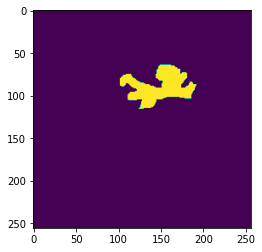

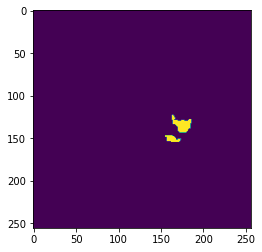

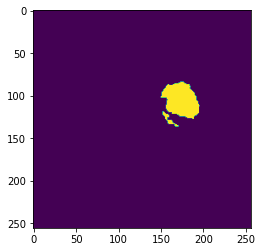

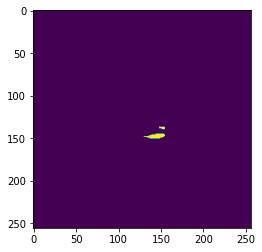

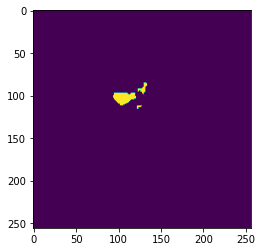

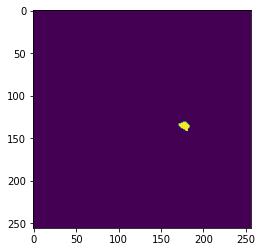

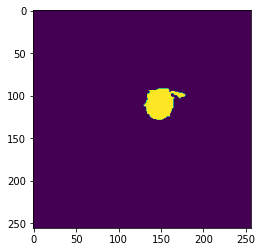

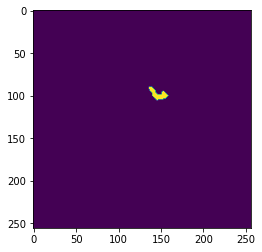

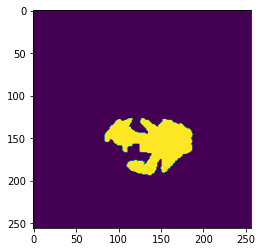

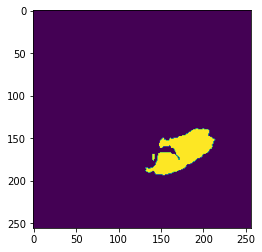

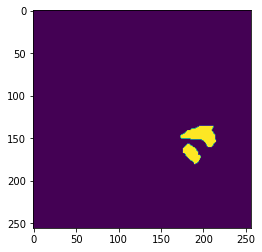

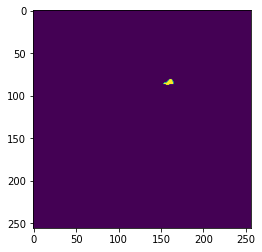

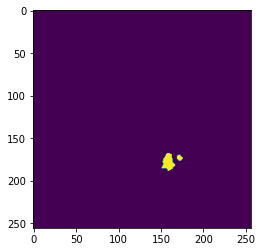

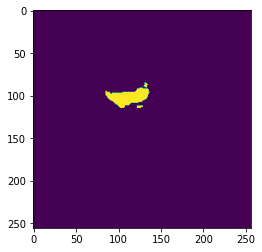

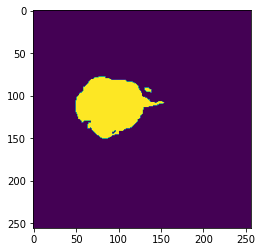

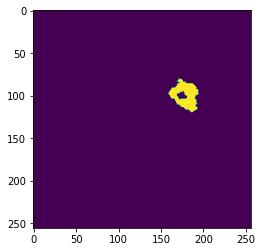

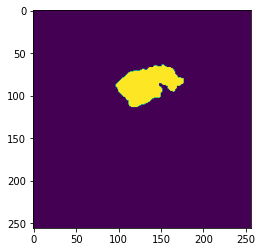

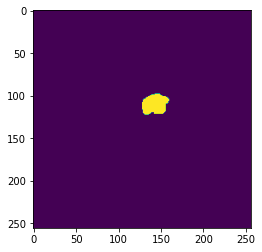

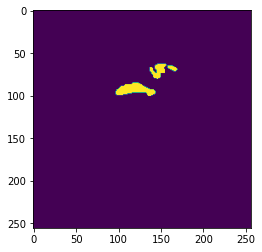

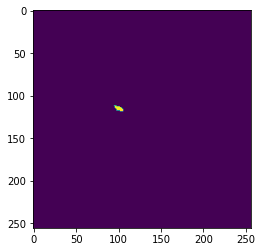

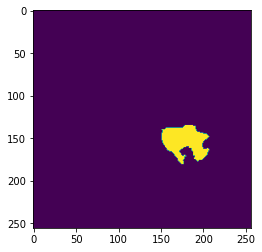

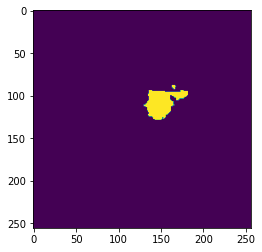

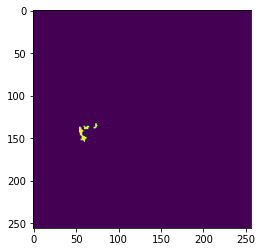

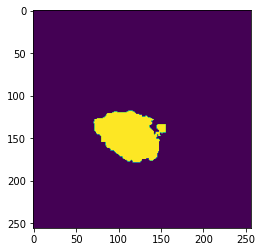

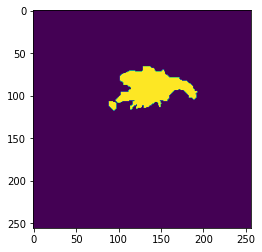

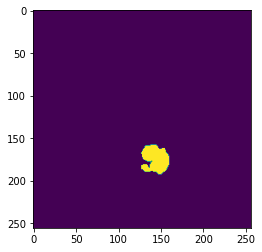

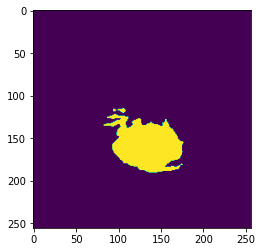

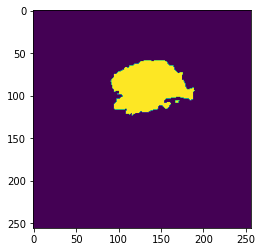

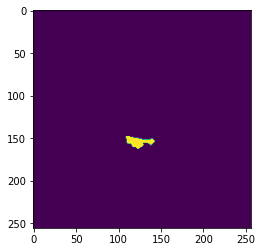

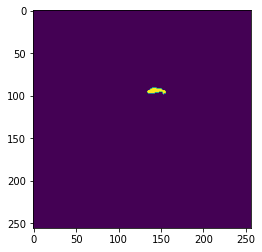

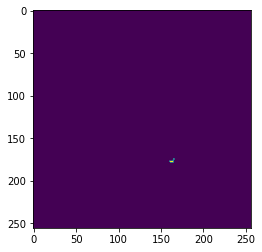

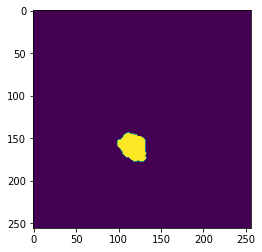

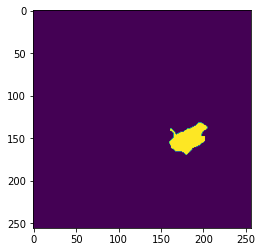

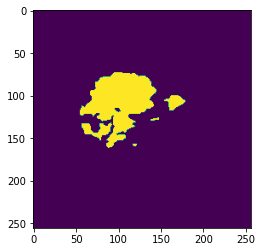

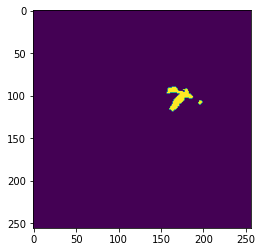

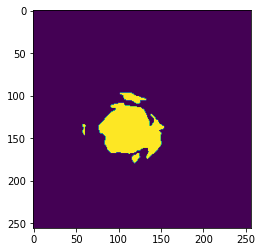

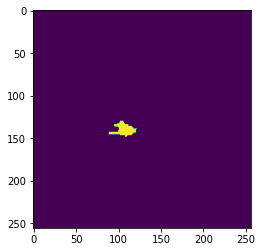

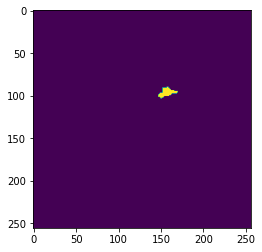

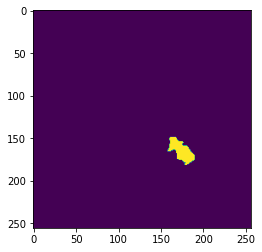

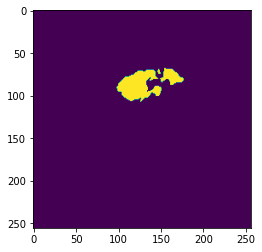

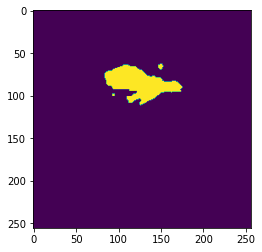

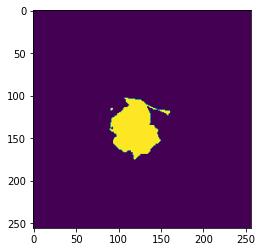

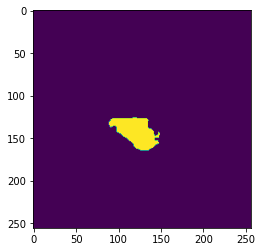

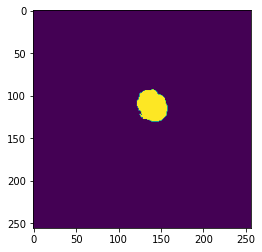

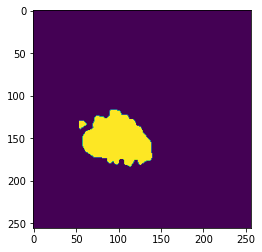

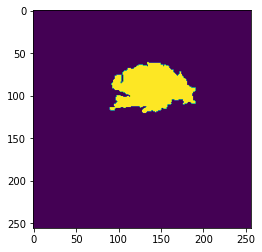

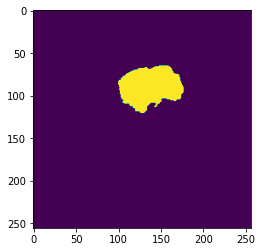

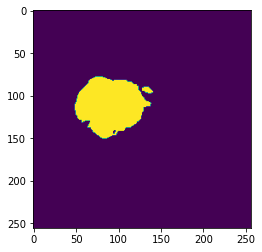

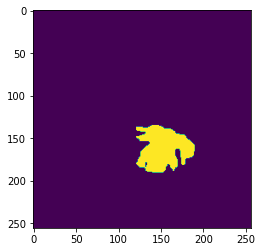

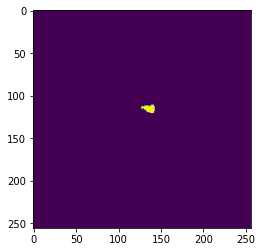

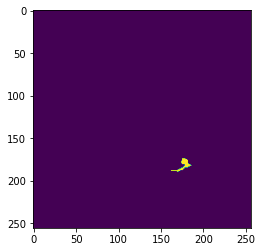

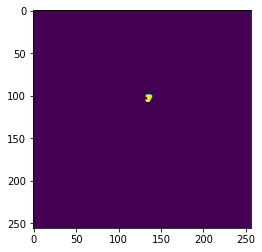

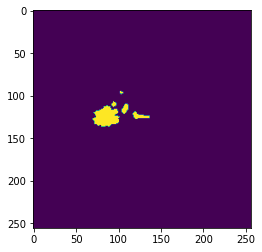

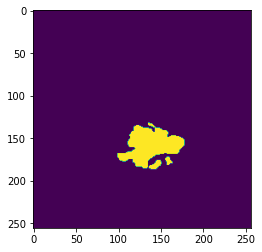

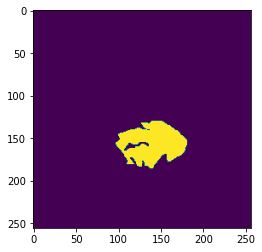

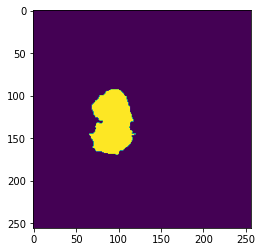

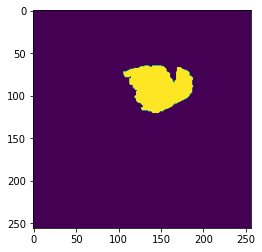

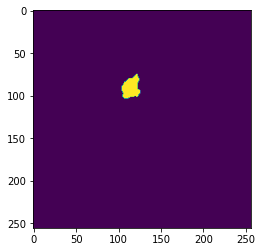

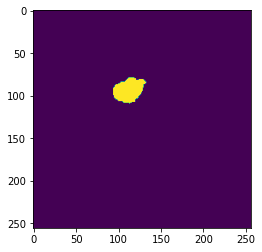

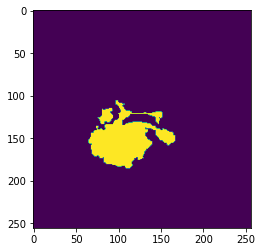

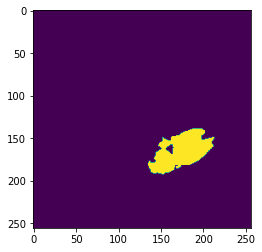

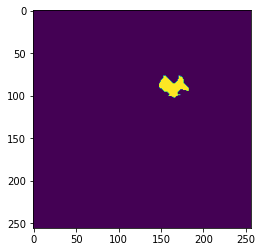

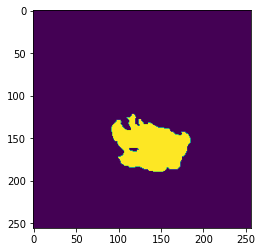

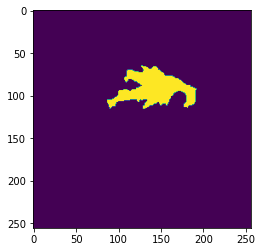

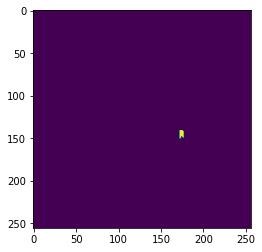

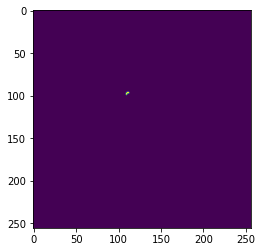

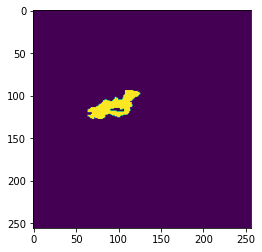

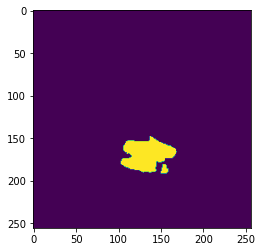

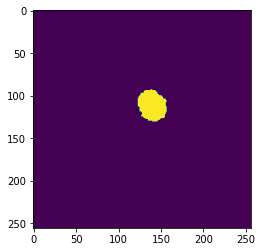

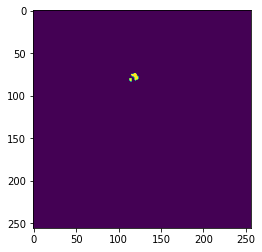

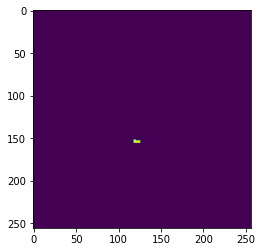

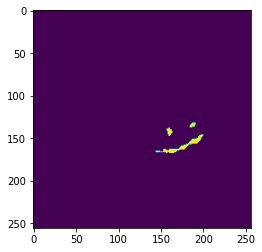

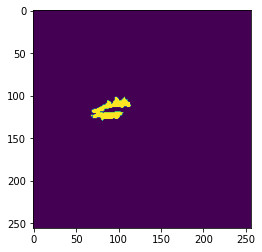

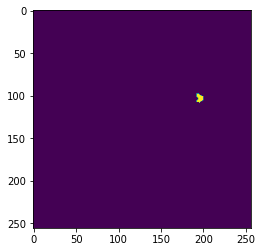

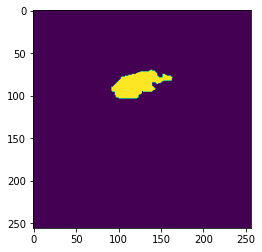

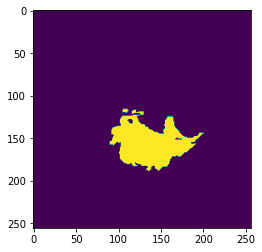

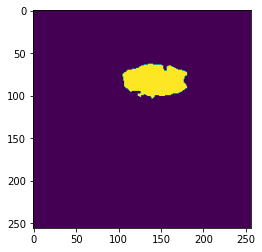

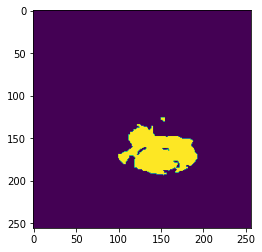

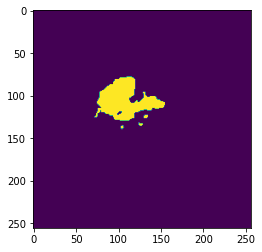

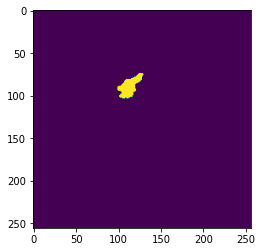

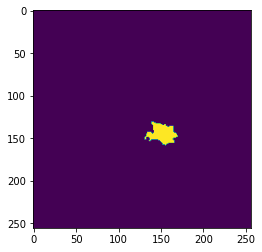

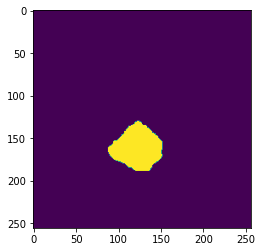

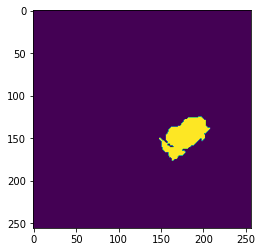

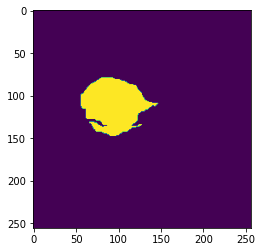

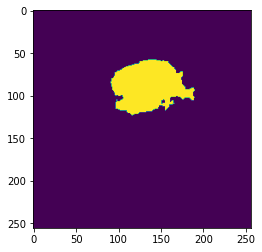

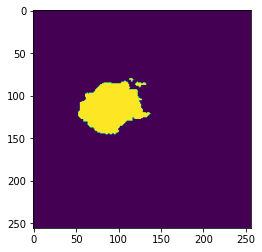

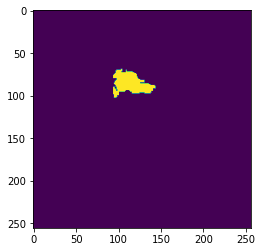

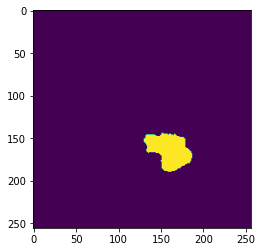

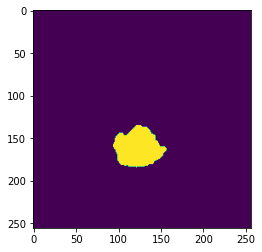

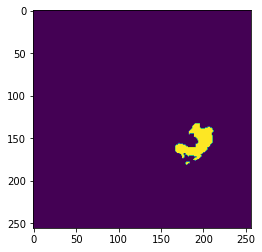

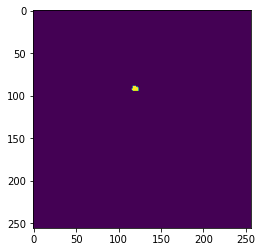

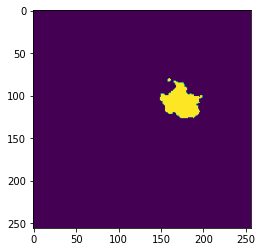

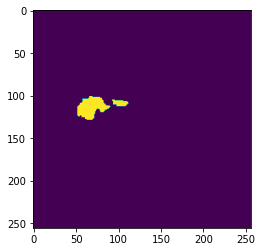

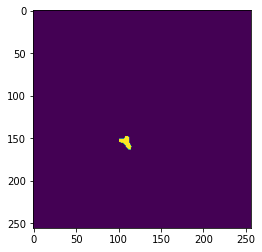

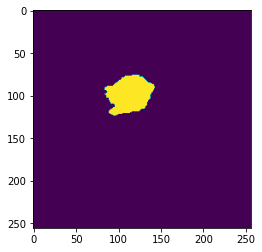

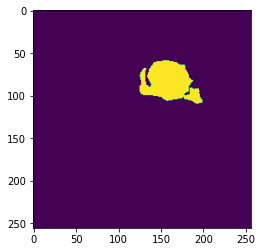

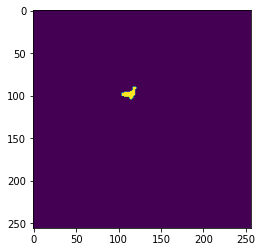

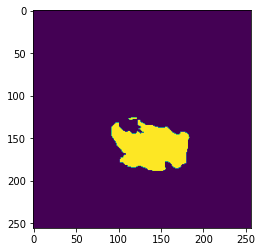

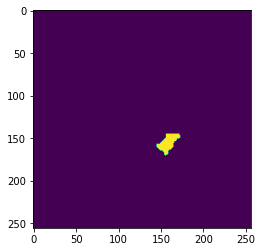

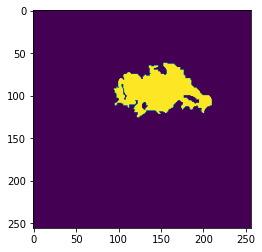

In [ ]:
for d in random.sample(coco_format["annotations"],100):
  plt.imshow(_mask.decode(d['segmentation']))
  plt.show()

In [ ]:
import base64
import IPython
import json
import numpy as np
import os
import random
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

In [ ]:
#@title

# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                        'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                        'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                        'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        #self.process_info()
        #self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')
        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_labels=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            from matplotlib import cm
            
            image = np.load(image_path)['arr_0']
            print(image.shape)
            image = PILImage.fromarray(np.uint8((image[:,:,3])))
            
            
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = "data:image/png;base64, " + base64.b64encode(buffered.getvalue()).decode()
        
        # Calculate the size and adjusted display size
        max_width = 900
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        labels = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))

            polygons[segm['id']] = polygons_list

            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            labels[segm['id']] = (self.categories[segm['category_id']]['name'], (bbox_points[0], bbox_points[1] - 4))
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))
            print(bbox)

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(img_str, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        if show_labels:
            for seg_id, label in labels.items():
                color = poly_colors[seg_id]
                html += '<text x="{}" y="{}" style="fill:{}; font-size: 8pt;">{}</text>'.format(label[1][0], label[1][1], color, label[0])
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [ ]:

annotation_path = r'/content/val.json'
image_dir = r'/content/images'

coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
# coco_dataset.display_licenses()
coco_dataset.display_categories()

Categories:
  super_category: wholeTumor
    id 1: wholeTumor



In [ ]:
html = coco_dataset.display_image('random', use_url=False)
IPython.display.HTML(html)

In [ ]:
import numpy as np

image = np.load('/content/train/image0_23.npz')


import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(8, 8))





fig.add_subplot(1,2,1)
#image = np.reshape(image, (240,240, 4))
plt.imshow(image[:,:,2])

plt.show()

print(image.shape)


# Matterspot fork = model trainnig

In [ ]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2

Cloning into 'Mask-RCNN-TF2'...
remote: Enumerating objects: 1434, done.
remote: Total 1434 (delta 0), reused 0 (delta 0), pack-reused 1434
Receiving objects: 100% (1434/1434), 144.54 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (802/802), done.


In [ ]:
!pip3 -q install -r /content/Mask-RCNN-TF2/requirements.txt

     |████████████████████████████████| 26.5 MB 1.7 MB/s 
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 377 kB 52.6 MB/s 
     |████████████████████████████████| 2.9 MB 41.1 MB/s 
     |████████████████████████████████| 454 kB 56.2 MB/s 
     |████████████████████████████████| 3.0 MB 43.1 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 154 kB 57.1 MB/s 
     |████████████████████████████████| 296 kB 59.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!cd /content/Mask-RCNN-TF2 && python3 /content/Mask-RCNN-TF2/setup.py install

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt


# Root directory of the project
ROOT_DIR = os.path.abspath("/content")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [ ]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    IMAGE_CHANNEL_COUNT = 4
    MEAN_PIXEL = 4
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
#@title

import os
import sys
import time
import numpy as np
import imgaug  # https://github.com/aleju/imgaug (pip3 install imgaug)

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import zipfile
import urllib.request
import shutil

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_DATASET_YEAR = "2014"

############################################################
#  Configurations
############################################################


class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes


############################################################
#  Dataset
############################################################

class CocoDatasetBrain(utils.Dataset):
    def load_coco(self,subset, class_ids=None,
                  class_map=None, return_coco=False):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """

        
        
        coco = COCO(f"/content/{subset}.json")
        
        image_dir = "/content/train"

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            print('loading a subset of classes')
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            print('loading all images')
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=coco.imgs[i]['file_name'],
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_coco:
            return coco

    

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                if m.shape[2]:
                  reduced=np.add.reduce(m,axis=2)
                  m = np.where(reduced>=2,0,reduced)
                
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDatasetBrain, self).load_mask(image_id)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = np.load(info['path'])['arr_0']
        
        
        return image
    def pad_with(vector, pad_width, iaxis, kwargs):
      pad_value = kwargs.get('padder', 10)
      vector[:pad_width[0]] = pad_value
      vector[-pad_width[1]:] = pad_value
    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rle = maskUtils.frPyObjects(segm, height, width)
            

        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m
    def pad_with(vector, pad_width, iaxis, kwargs):
      pad_value = kwargs.get('padder', 10)
      vector[:pad_width[0]] = pad_value
      vector[-pad_width[1]:] = pad_value

############################################################
#  COCO Evaluation
############################################################

def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results


def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)







In [ ]:
datTrain = CocoDatasetBrain()
datTrain.load_coco(subset='train')

loading annotations into memory...
Done (t=2.29s)
creating index...
index created!
loading a subset of classes


In [ ]:
datTrain.prepare()

In [ ]:
datTrain.num_images

21763

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


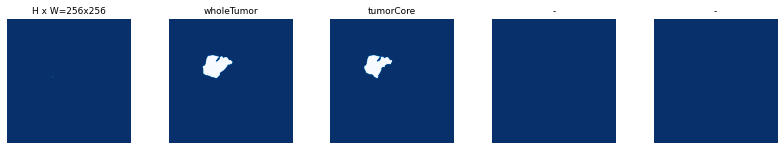

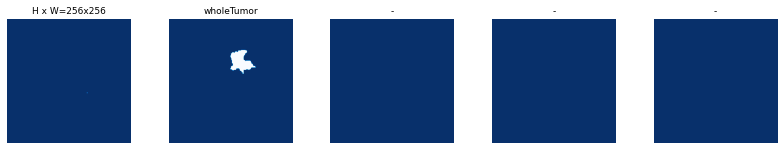

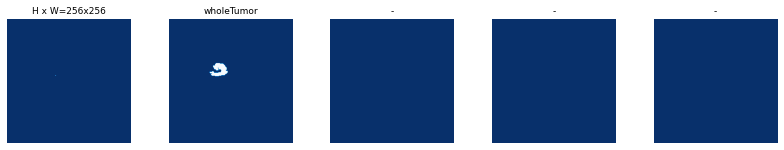

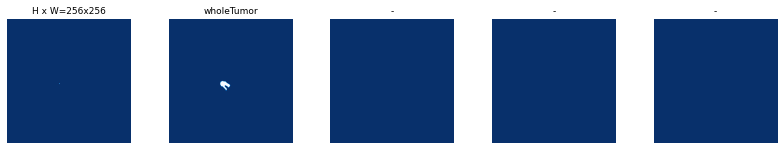

In [ ]:
image_ids = np.random.choice(datTrain.image_ids, 4)
for image_id in image_ids:
    image = datTrain.load_image(image_id)
    mask, class_ids = datTrain.load_mask(image_id)
    visualize.display_top_masks(image[:,:,3], mask, class_ids, datTrain.class_names)

In [ ]:
datval = CocoDatasetBrain()
datval.load_coco(subset='val')
datval.prepare()

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights('/content/mask_rcnn_coco.h5', by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask","conv1"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights('/content/drive/MyDrive/mask_rcnn_shapes_0009.h5', by_name=True)

In [ ]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [ ]:
trainble_layers = r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)|(conv1)"
model.train(datTrain,datval,
            learning_rate=config.LEARNING_RATE*0.5, 
            epochs=10, 
            layers=trainble_layers)


Starting at epoch 0. LR=0.0005

Checkpoint Path: //logdir//train/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_ma

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


100/100 [==============================] - 264s 3s/step - loss: 2.9617 - val_loss: 2.5906
Epoch 2/10
100/100 [==============================] - 182s 2s/step - loss: 2.4339 - val_loss: 2.4576
Epoch 3/10
100/100 [==============================] - 182s 2s/step - loss: 2.2766 - val_loss: 2.1432
Epoch 4/10
100/100 [==============================] - 181s 2s/step - loss: 2.3035 - val_loss: 1.8824
Epoch 5/10
 57/100 [================>.............] - ETA: 1:16 - loss: 2.2912

 58/100 [================>.............] - ETA: 1:14 - loss: 2.2858

100/100 [==============================] - 182s 2s/step - loss: 2.2205 - val_loss: 2.0856
Epoch 6/10
100/100 [==============================] - 182s 2s/step - loss: 2.2249 - val_loss: 3.3024
Epoch 7/10
 57/100 [================>.............] - ETA: 1:15 - loss: 2.1122

 58/100 [================>.............] - ETA: 1:13 - loss: 2.1142

100/100 [==============================] - 183s 2s/step - loss: 2.0930 - val_loss: 2.3280
Epoch 8/10
100/100 [==============================] - 179s 2s/step - loss: 2.1197 - val_loss: 4.2181
Epoch 9/10
 39/100 [==========>...................] - ETA: 1:46 - loss: 2.2003

 40/100 [===========>..................] - ETA: 1:44 - loss: 2.1958

100/100 [==============================] - 180s 2s/step - loss: 2.1341 - val_loss: 2.3289
Epoch 10/10
100/100 [==============================] - 179s 2s/step - loss: 2.1019 - val_loss: 2.0133


In [ ]:
model.load_weights('/logdir/train/mask_rcnn_shapes_0004.h5', by_name=True)

In [ ]:

from tensorflow.keras.callbacks import Callback,EarlyStopping
class NBatchLogger(Callback):
    "A Logger that log average performance per `display` steps."

    def __init__(self):
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        for k in logs.keys():
          if batch == 0 and self.epoch == 0:
            self.metric_cache[k] = [logs[k]]
          else:
            self.metric_cache[k].append(logs[k])

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

In [ ]:
mycall = NBatchLogger()
history = model.train(datTrain,datval,
            learning_rate=config.LEARNING_RATE*0.1, 
            epochs=10, 
            layers='all',
            custom_callbacks=[
                  EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True),
                  mycall
                   ])


Starting at epoch 0. LR=0.0001

Checkpoint Path: //logdir//train/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


100/100 [==============================] - 314s 3s/step - loss: 2.0660 - val_loss: 2.0554
Epoch 2/10
100/100 [==============================] - 213s 2s/step - loss: 1.9946 - val_loss: 2.1131


Text(0.5, 1.0, 'Accuracy per step')

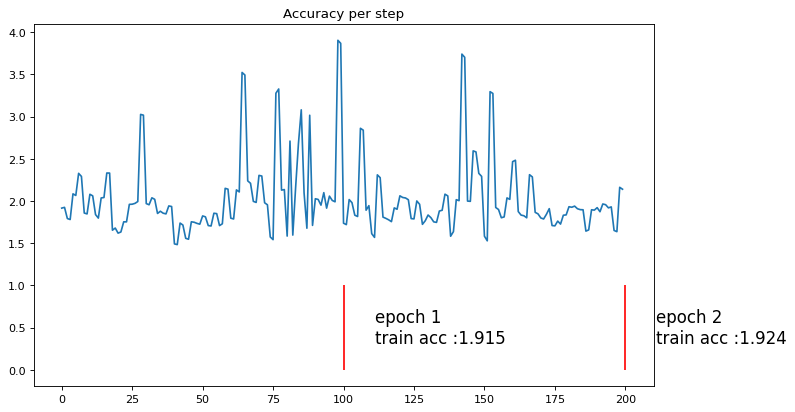

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import text 
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(mycall.metric_cache['loss'] )
epochs = 2
steps = 100 * epochs
dline = 100
i = 0
for e in range(dline, steps + 1, dline):
  
  plt.vlines(x=e, color = 'r', ymin = 0, ymax = 1)
  trainAcc = "\ntrain acc :" + str(round(mycall.metric_cache['loss'][i], 3))
  textl = "epoch " + str(i+1) + trainAcc 
  text(e+11,0.5,textl , rotation=0, verticalalignment='center', fontsize= 15)
  i += 1

plt.title("Accuracy per step")

In [ ]:
import os
import glob
# my all files starts with "frame" and ends with ".jpg"
fileList = glob.glob('/content/drive/MyDrive/image*.npz')
print("Number of files: ",len(fileList))

for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Number of files:  8


In [ ]:
!du -sh  /content/*

7.3G	/content/drive
246M	/content/mask_rcnn_coco.h5
253M	/content/Mask-RCNN-TF2
3.1G	/content/MICCAI_BraTS2020_TrainingData
55M	/content/sample_data
2.8G	/content/train
46M	/content/train.json
2.5G	/content/train.tar.gz
12M	/content/val.json


In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='/logdir/train')

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


# Load trained weights

model.load_weights('/logdir/train/mask_rcnn_shapes_0002.h5', by_name=True)

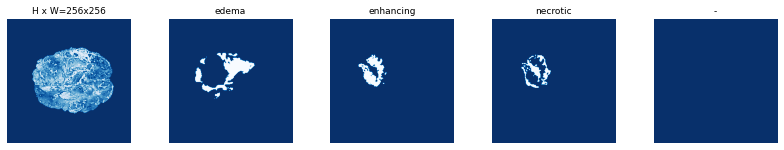

In [ ]:
image_id = random.choice(datval.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(datval, inference_config, 
                           image_id, use_mini_mask=False)
visualize.display_top_masks(original_image[:,:,3],  gt_mask, gt_class_id, datval.class_names)

Processing 1 images
image                    shape: (256, 256, 4)         min:    0.00000  max: 3478.00000  float64
molded_images            shape: (1, 256, 256, 4)      min:   -4.00000  max: 3474.00000  float32
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


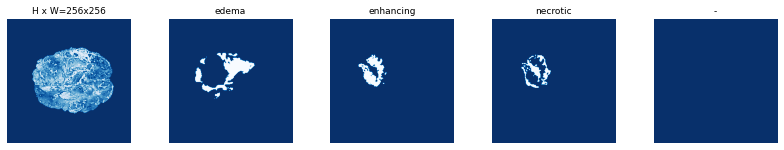

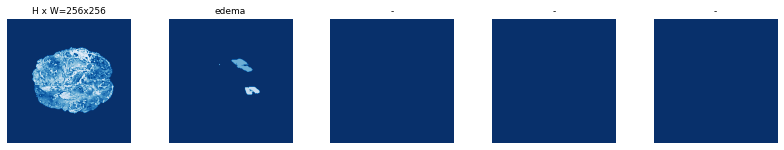

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_top_masks(original_image[:,:,3],  gt_mask, gt_class_id, datval.class_names)
visualize.display_top_masks(original_image[:,:,3],  r['masks'], r['class_ids'], datval.class_names)

# validation code

In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
from collections import defaultdict
image_ids = datval.image_ids[:200]
APs = []
dice =defaultdict(list)

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(datval, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
    count=0
    for i in gt_class_id:

      indices = np.where(r['class_ids'] == i)[0]
      if len(indices )==0:
        dice[i].append(0)
      else:
        m = np.take(r['masks'], indices,axis=2)
        if m.shape[2]:
                        reduced=np.add.reduce(m,axis=2)
                        m = np.where(reduced>=2,1,reduced)
        
        dice[i].append(dice_coef_metric(gt_mask[:,:,count],m))
      count+=1
    
print("mAP: ", np.mean(APs,))
for key,val in dice.items():
  print(f'mean dice of {key}: {np.mean(dice[key],)}')

mAP:  0.004916666666666666
mean dice of 2: 0.1195018165678009
mean dice of 1: 0.0
mean dice of 3: 0.0


In [ ]:
coco=COCO('/content/train.json')

loading annotations into memory...
Done (t=1.36s)
creating index...
index created!


In [ ]:

# Define the classes (out of the 81) which you want to see. Others will not be shown.
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
for cat in cats:

  # Fetch class IDs only corresponding to the filterClasses
  catIds = coco.getCatIds(catNms=cat['name']) 
  # Get all images containing the above Category IDs
  imgIds = coco.getImgIds(catIds=catIds)
  print(cat['name'])
  print("Number of images containing all the  classes:", len(imgIds))


necrotic
Number of images containing all the  classes: 11687
edema
Number of images containing all the  classes: 19098
enhancing
Number of images containing all the  classes: 11418
